# Which Watts Win at Zwift?
I'm an avid cyclist and, like many, the long lonely winters of Covid-19 had me engage much more with [Zwift](zwift.com), a virtual cycling environment for casual riding, training and racing. I had toyed with Zwift in the past but always struggled to engage, cycling on my own in my garage didn't provide the positive feedback I need to keep pedalling. That was, until I learnt about the [Donny Chain Gang](https://www.donnychaingang.net/) an 'in real life' club that had started to host bi-weekly rides. Each ride started as a social and ended as an all-out race to the finish. I was hooked. The competitive edge meant i needed to pay attention to how much effort I was expending and when. Whilst before I was struggling to turn the pedals, suddenly I found myself digging deep to sprint because another rider was getting away. I was hooked. 

In addition to the cycling aspect, there was a whole new world of power numbers to obsess over. Zwift created a 'virtual world' with realistic physics. As such, different riders will have an advantage depending on the type of terrain. Lighter riders tend to do better up hillier terrain, riders with raw power will have an advantage on the flat. 

However, things are complicated further, Zwift also has a version of 'drafting' too. If you hide behind another rider when travelling at speed you can keep up with them while generating a smaller amount of power. This advantage diminishes as the road becomes steeper and speeds become lower. This introduces a fantastic, realistic tactical element that makes the racing so fun. The effect of this is that flatter racing is often determined by a rider's ability to sprint -- very high, short term power to get away from a group and 'snapping the elastic' linking a rider to those behind.

### Categories
To try and keep things fair, Zwift categorises each rider according to the power numbers they are able to generate. As cyclists come in all shapes and sizes, Zwift use a specific measurement of Watts generated _per_ kg of rider $W/kg$. I.e. a lighter rider only has to generate a smaller number of watts to be considered equivalent to a heavier rider generating more watts. 
When racing, you will generally do so in a specific category, A, B, C, D etc. members are put into a category according to the average $W/kg$ they can generate for a long period (20 to 40 minutes) or around 5 minutes [details](https://zwiftinsider.com/category-enforcement/). 

This is a singular way of measuring performance, they are values taken from a riders _power curve_ which shows a rider's performance over various different time periods. Shorter, 5 to 60 second power values could be seen as a rider's sprinting ability, while longer power values get close to their _threshold power_, how much power a rider is able to generate for a long time.
Here's a picture of my power curve I generated using the free software [Golden Cheetah](https://www.goldencheetah.org/)

![My power curve](CP.png "Power Curve")


This raises the question, is this the right way to categorise a rider? Do longer (5, 20 minute) power values best represent performance and a rider's ability to compete in the Zwift racing environment?
There is much discussion about the suitability of Zwift categories and much effort has been expended in suggesting alternatives ([more on that later](https://www.zwiftracing.app/)).

In [1]:
import json
import numpy as np
import pandas as pd
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")


## Race Results
To explore this question I downloaded the race results from a particular race series, the [Herd](http://theherd.club/) Winter racing series. This race has the advantage that it's completely open and doesn't use categories at all. Therefore, riders are unfiltered. I chose two courses, a flatter course and a hillier course. I downloaded all race results from a single day in each case (the race series runs many times in a day), I thought it was less likely to have the same rider appear twice in this way (I can't imagine it likely that someone would race the same course twice in a single day).
I didn't do anything fancy here, simply downloaded the JSON file used by the [Zwiftpower](https://zwiftpower.com/) website directly from my browser. I used a simple python script to combine the races into two text files. 

We can load the data from each and store each race in a list object.

In [2]:
# Load a file
with open('./data/hill.txt') as file:
    distance = file.readline()
    height = file.readline()
    races_json_h = file.readlines()
with open('./data/flat.txt') as file:
    distance = file.readline()
    height = file.readline()
    races_json_f = file.readlines()

I will load the key power values from our results, in addition to the finishing time of each racer.

In [3]:
def extract_race_data(json_str):
    '''
    Load the JSON as a dictionary object and manipulate to get the data required
    '''
    data = json.loads(json_str)['data']
    raced = [
        {
            'time': result['time_gun'],
            '20min': float(result['wkg1200'][0]),
            '5min': float(result['wkg300'][0]),
            '2min': float(result['wkg120'][0]),
            '1min': float(result['wkg60'][0]),
            '30sec': float(result['wkg30'][0])
        }
        for result in data
    ]
    race = pd.DataFrame(raced)
    
    return race

Given that each race might be different in terms of competitors and the dynamics (how hard it's ridden, groups that develop etc.) I turned the absolute values of time and power into ranks. We are interested in how riders compare to other riders in terms of finishing position and power generation.

In [4]:
all_races_list_f = [extract_race_data(races) for races in races_json_f]
all_races_list_h = [extract_race_data(races) for races in races_json_h]
all_races_list = all_races_list_f + all_races_list_h
all_races_rank = []
for i,race in enumerate(all_races_list_f):    
    race_rank = race.apply(lambda s: s.rank() if s.name == 'time' else s.rank(ascending=False),axis=0)
    race_rank['course'] = 'flat'
    all_races_rank.append(race_rank)

for i,race in enumerate(all_races_list_h):
    race_rank = race.apply(lambda s: s.rank() if s.name == 'time' else s.rank(ascending=False),axis=0)
    race_rank['course'] = 'hilly'
    all_races_rank.append(race_rank)

races = pd.concat(all_races_list,axis=0)
races_rank = pd.concat(all_races_rank,axis=0)
races_rank = races_rank.melt(id_vars=['time','course'],value_vars=['20min','5min','2min','1min','30sec'],var_name='power_stat',value_name='value')
races = races.melt(id_vars=['20min'],value_vars=['5min','2min','1min','30sec'],var_name='power_stat',value_name='value')

## Power Generation and finishing position
Let us examine where someone finishes depending on their power generation ability. Rather than look just at the 20 minute and 5 minute power values, we can look at shorter periods to: 2 minutes, 1 minute and 30 second powers in $W/kg$.
In addition to this, we can examine the correlation between power generation and finishing position. The closer the 'r' value is to 1, the better the relationship.

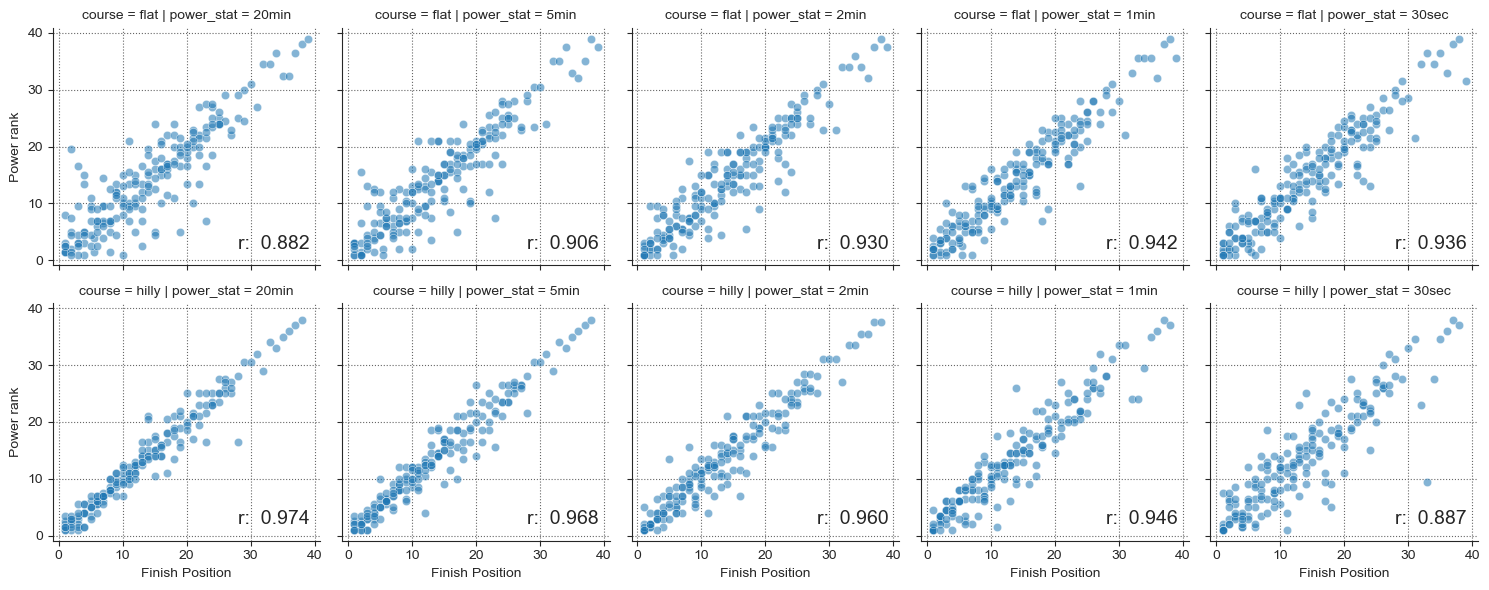

In [5]:
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
def corr_text(*args,**kwargs):
    # Get correlation from x, y
    x = args[0]
    y = args[1]
    r = pearsonr(x,y)
    
    plt.text(28,2,f'r: {r.statistic: .3f}',fontsize=14)
    plt.grid(linestyle=':',color=[0.4,0.4,0.4])

sns.set_style('ticks')
g = sns.FacetGrid(data = races_rank,col='power_stat',row='course')
g.map(sns.scatterplot,'time','value',alpha=0.55)
g.map(corr_text,'time','value')
g.set_axis_labels(x_var='Finish Position',y_var='Power rank')

plt.show()

The plots above show the relationships for a flat course (at the top) and a hilly course (at the bottom). Longer power generation values are to the left, starting with 20 minute power. Shorter power generation values are to the right, finishing with 30 second power. 
As one might be able to predict, the finishing position in a hillier course is much better predicted by longer power generation ability than short. A flatter course is better predicted by shorter power generation ability -- but is, in general a little less predictable. An extra dimension, tactical ability, is not accounted for here. 

## Short-term or long-term?
So given this, how effective do we think Zwift's categorisation method is? Is a focus on longer term power generation the right approach? It works well for hillier races, but is not as good as short term power on flatter courses.

However, this need not be a problem if a riders _short term_ power generation is strongly related to their _longer term_ power generation ability. You can pick one or the other and they will both be effective.

Let us examine this by plotting 20 minute power against every other power level.

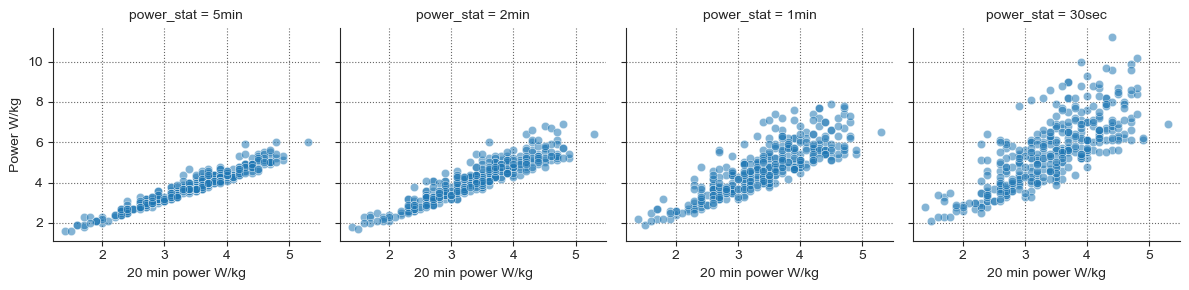

In [6]:

g = sns.FacetGrid(data = races,col='power_stat')
g.map(sns.scatterplot, '20min','value',alpha=0.55)
g.set_axis_labels(x_var='20 min power W/kg',y_var='Power W/kg')
g.map(plt.grid,linestyle=':',color=[0.4,0.4,0.4])
plt.show()

A couple of things that can be gleaned just from looking at these plots. 
1. Shorter term power generation is much harder to predict using 20 minute power than say, 5 minute power. 
2. The relationships are _heteroscedastic_. This means that the variability of output increases as the value of our predictor increases.

With regards to point 2, the increased variability means that more powerful riders are much harder to predict than less powerful riders. In other words, the Zwift categories do a poor job of separating people with regards to shorter term power generation.
This becomes more obvious if we look at riders with a 'high' (greater than 3.5 $W/kg$) 20 minute power output. 

__NB:__ You may have noticed a weird shape to the plots, particularly on the left. It appears that there is a straight edge to the bottom of the plot. This is the $x=y$ line. Due to the way the power values are calculated a shorter term power value can never be lower than it's longer term equivalent. So for example, if your 20 minute power is 3 $W/kg$, your 5 minute power is _at least_ 3 $W/kg$. This appears as a hard edge on some plots as no points can exist below this $x=y$ line.

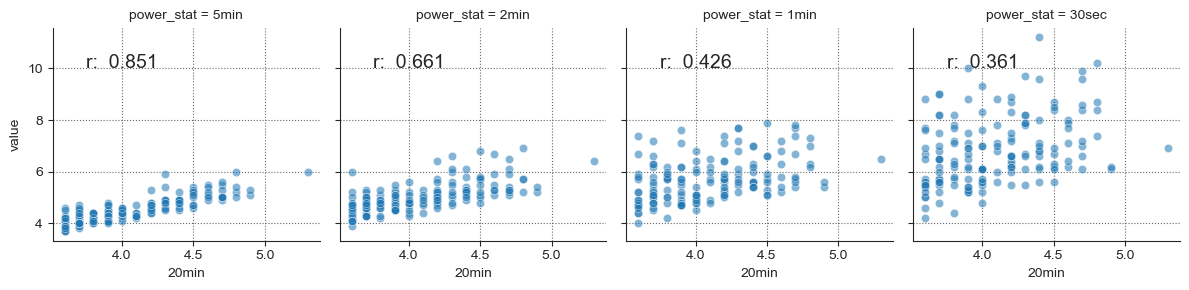

In [10]:
def corr_text(*args,**kwargs):
    # Get correlation from x, y
    x = args[0]
    y = args[1]
    r = pearsonr(x,y)
    plt.text(3.75,10,f'r: {r.statistic: .3f}',fontsize=14)

races_trim = races.loc[races['20min'] > 3.5]
g = sns.FacetGrid(data = races_trim,col='power_stat')
g.map(sns.scatterplot, '20min','value',alpha=0.55)
g.set_axis_labels(x_var='20 min power W/kg',y_var='Power W/kg')
g.map(corr_text,'20min','value')
g.map(plt.grid,linestyle=':',color=[0.4,0.4,0.4])
plt.show()

I have put the value of Pearson's r on the plot too. You can see that correlation is decent (~ 0.85) for 5 minute power generation, which is interesting because Zwift uses this for categorisation anyway. However, when we look at 1 minute and 30 second power -- values that are good predictors of success in flatter races -- correlation is poor. In other words, with Zwift's categorisation, there are racers in category B that would be expected to outperform racers in category A on flatter races.

## Alternatives?
As mentioned previously, alternative attempts at categorisation have been made. I love the [Zwiftracing website](https://www.zwiftracing.app/) approach, each rider has a rank based on the rank of opponents they have beaten in races. The more races you compete in, the more accurate the rank becomes. This is a similar approach to [ELO in chess](https://en.wikipedia.org/wiki/Elo_rating_system) (in fact, the ranking score is called vELO). I like it because it doesn't attempt to predict race results by measuring separate mechanics of performance. It predicts race results (and categories) by measuring how well you do in races! A wholistic combination of your power, tactics and even mental fortitude. It's all in there. As we've shown in this analysis, performance can vary depending on the type of course (hilly, flat etc.) but that's all accounted for in the calculations. Come on Zwift adopt this method!